In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
plt.rcParams["figure.figsize"] = (10,10)

In [27]:
# labelling 
# Normal : 0
# Spondylolisthesis : 1
# Hernia : 2

In [28]:
def convert_labels(y):
    j = y.copy()
    j[j=='Normal'] = 0
    j[j=='Spondylolisthesis'] = 1
    j[j=='Hernia'] = 2
    j = j.astype('int32')
    return j
    

### Loading the Dataset

In [29]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = convert_labels(pd.read_csv('y_train.csv')['class'])
y_test = convert_labels(pd.read_csv('y_test.csv')['class'])

### Defining the metrics 

In [30]:
def Normalprecision(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def NormalRecall(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())


def Spondprecision(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def SpondRecall(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())

def Herniaprecision(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def HerniaRecall(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())


def computemetrics(y_true, y_pred):
    return {'Normalprecision':Normalprecision(y_true, y_pred),
            'NormalRecall':NormalRecall(y_true, y_pred),
            'Spondprecision':Spondprecision(y_true, y_pred),
            'SpondRecall':SpondRecall(y_true, y_pred),
            'HerniaPrecision':Herniaprecision(y_true, y_pred),
             'HerniaRecall':HerniaRecall(y_true, y_pred)}

### Defining a GridEval class that 

In [31]:
class GridEval:
    def __init__(self, pipe, param, cross, x_train, y_train, x_test, y_test):
        self.pipe = pipe
        self.param = param
        self.cross = cross
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    def fit(self):
        scores = ['NormalPrecision','NormalRecall', 'SpondPrecision', 'SpondRecall', 'HerniaPrecision',
                                                 'HerniaRecall']
        grids = [GridSearchCV(estimator = self.pipe, param_grid = self.param,
                             scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                             cv = self.cross,
                             n_jobs = -1,
                             refit = i) for i in scores]
        for g in grids:
            print(g.get_params()['refit'])
            g.fit(self.x_train, self.y_train)

        best_models = [g.best_estimator_ for g in grids]
        cv_results = {g.get_params()['refit']:pd.DataFrame(g.cv_results_) for g in grids}
        result = {}
        for i in range(len(best_models)):
            result[grids[i].get_params()['refit']] = computemetrics(self.y_test, best_models[i].predict(self.x_test))

        return best_models, result, cv_results

    
    
    

In [32]:
pipe = Pipeline([('transformer', QuantileTransformer(n_quantiles = 100)),
                 ('model', LogisticRegression())])

param = {'model__class_weight':[{0:v-1, 1:1, 2:v} for v in range(2, 10)]}

In [33]:
grid = GridEval(pipe, param, 5, x_train, y_train, x_test, y_test)

In [34]:
models, result, cv_results = grid.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


In [77]:
def plot(cv_result, title, xlabel, ylabel):
    scores = ['NormalPrecision','NormalRecall', 'SpondPrecision', 'SpondRecall', 'HerniaPrecision','HerniaRecall']
    for i in scores:
        plt.plot(np.arange(2,2+cv_result.shape[0]), cv_result[f'mean_test_{i}'], label = i)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    

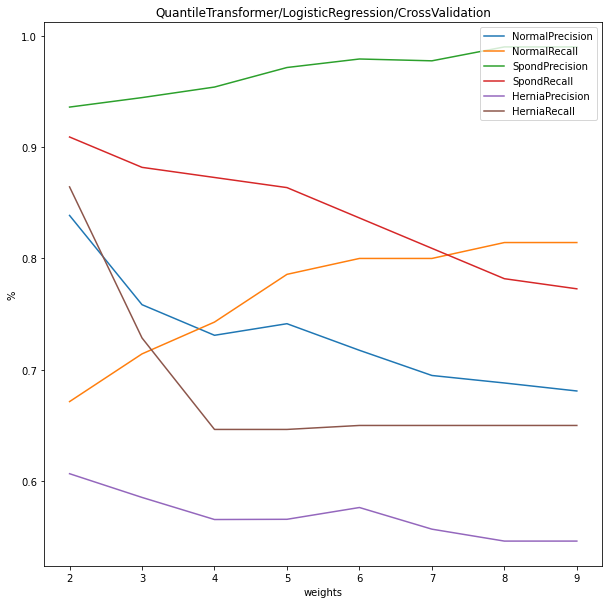

In [78]:
plot(cv_results['NormalPrecision'], 'QuantileTransformer/LogisticRegression/CrossValidation', 'weights', '%')

In [37]:
pipe2 = Pipeline([('transformer', StandardScaler()),
                 ('model', LogisticRegression())])

In [38]:
grid2 = GridEval(pipe2, param, 5, x_train, y_train, x_test, y_test)

In [39]:
models2, result2, cv_results2 = grid2.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


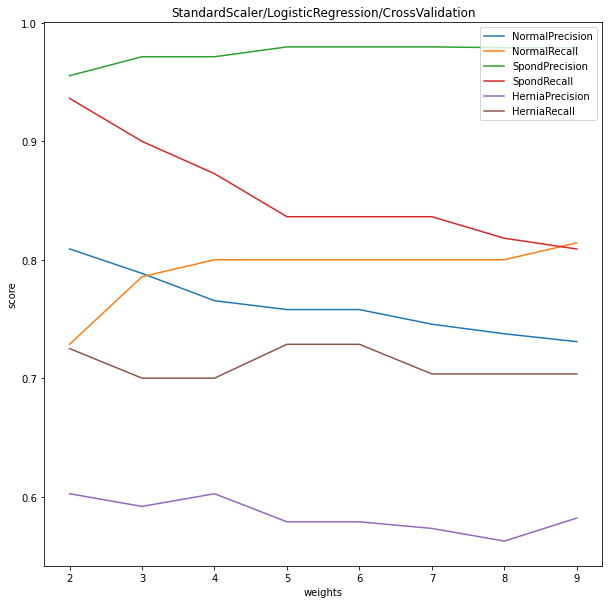

In [79]:
plot(cv_results2['NormalPrecision'], 'StandardScaler/LogisticRegression/CrossValidation', 'weights', 'score')

In [42]:
pipe3 = Pipeline([('transformer', RobustScaler()),
                 ('model', LogisticRegression())])

In [43]:
grid3 = GridEval(pipe3, param, 5, x_train, y_train, x_test, y_test)

In [44]:
models3, result3, cv_results3 = grid3.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


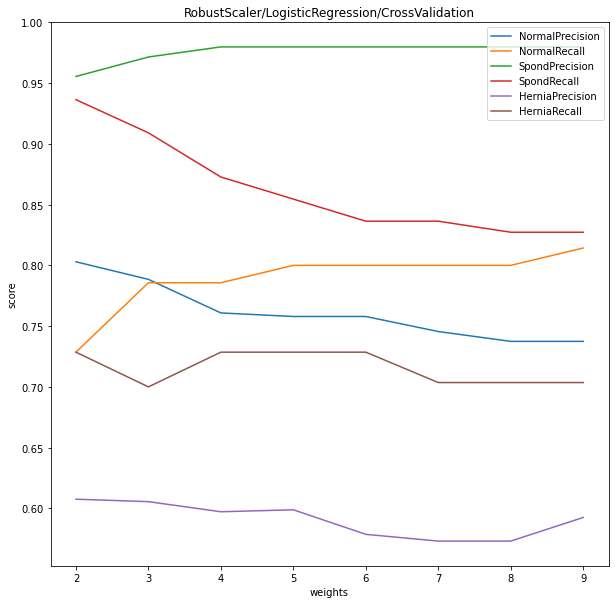

In [80]:
plot(cv_results3['NormalPrecision'], 'RobustScaler/LogisticRegression/CrossValidation', 'weights', 'score')

### Applying Power Transformation to data to make it more Gaussian Like

#### (yeo_johnson method)

In [48]:
pipe4 = Pipeline([('transformer', PowerTransformer()),
                  ('model', LogisticRegression())])

In [49]:
grid4 = GridEval(pipe4, param, 5, x_train, y_train, x_test, y_test) 

In [50]:
models4, result4, cv_results4 = grid4.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


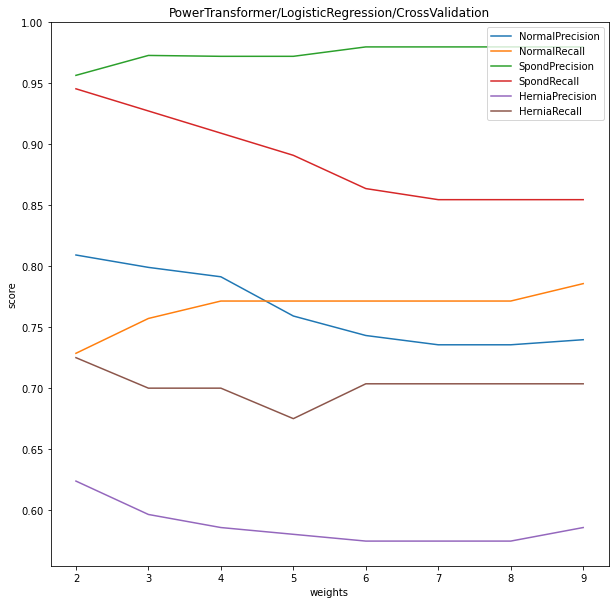

In [81]:
plot(cv_results4['NormalPrecision'], 'PowerTransformer/LogisticRegression/CrossValidation', 'weights', 'score')

## From the performance of LogisticRegression on various different transformations
## RobustScaling with a class weight of {0:1, 1:1, 2:2} performs the best

In [87]:
robust_pipe = Pipeline([('transformer', RobustScaler()),
                       ( 'model', LogisticRegression(class_weight = {0:1, 1:1, 2:2}, max_iter = 1000))])
robust_pipe.get_params()

{'memory': None,
 'steps': [('transformer', RobustScaler()),
  ('model',
   LogisticRegression(class_weight={0: 1, 1: 1, 2: 2}, max_iter=1000))],
 'verbose': False,
 'transformer': RobustScaler(),
 'model': LogisticRegression(class_weight={0: 1, 1: 1, 2: 2}, max_iter=1000),
 'transformer__copy': True,
 'transformer__quantile_range': (25.0, 75.0),
 'transformer__unit_variance': False,
 'transformer__with_centering': True,
 'transformer__with_scaling': True,
 'model__C': 1.0,
 'model__class_weight': {0: 1, 1: 1, 2: 2},
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [98]:
robust_grid = GridSearchCV(estimator = robust_pipe,
                          param_grid = {'model__C' : np.linspace(0.1, 10, 100)},
                          scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                             cv = 5,
                             n_jobs = -1,
                          refit = 'SpondPrecision')

In [99]:
robust_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 1,
                                                                         2: 2},
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4....
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])},
             refit='SpondPrecision',
   

In [100]:
robust_results = pd.DataFrame(robust_grid.cv_results_)

Text(0, 0.5, 'score')

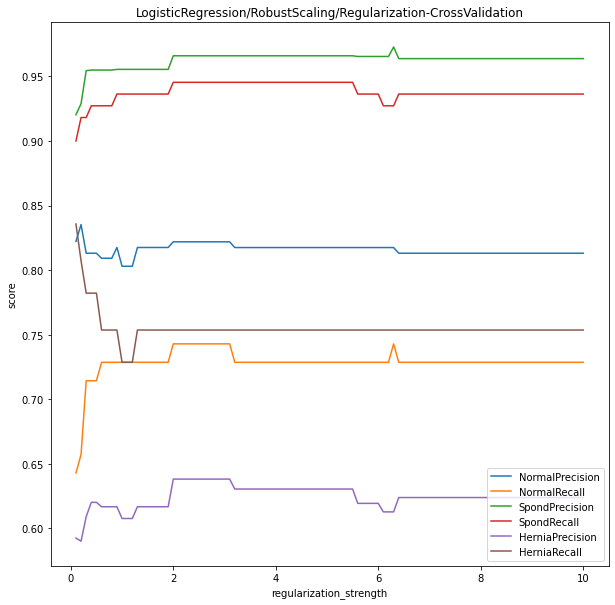

In [101]:
scores = ['NormalPrecision','NormalRecall', 'SpondPrecision', 'SpondRecall', 'HerniaPrecision','HerniaRecall']
for i in scores:
    plt.plot(robust_results['param_model__C'], robust_results[f'mean_test_{i}'], label = i)
plt.legend()
plt.title('LogisticRegression/RobustScaling/Regularization-CrossValidation')
plt.xlabel('regularization_strength')
plt.ylabel('score')


## Around 2.1 seems to be an optimal choice of regularization strength 

In [108]:
robust_grid.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('transformer', RobustScaler()),
  ('model',
   LogisticRegression(class_weight={0: 1, 1: 1, 2: 2}, max_iter=1000))],
 'estimator__verbose': False,
 'estimator__transformer': RobustScaler(),
 'estimator__model': LogisticRegression(class_weight={0: 1, 1: 1, 2: 2}, max_iter=1000),
 'estimator__transformer__copy': True,
 'estimator__transformer__quantile_range': (25.0, 75.0),
 'estimator__transformer__unit_variance': False,
 'estimator__transformer__with_centering': True,
 'estimator__transformer__with_scaling': True,
 'estimator__model__C': 1.0,
 'estimator__model__class_weight': {0: 1, 1: 1, 2: 2},
 'estimator__model__dual': False,
 'estimator__model__fit_intercept': True,
 'estimator__model__intercept_scaling': 1,
 'estimator__model__l1_ratio': None,
 'estimator__model__max_iter': 1000,
 'estimator__model__multi_class': 'auto',
 'estimator__model__n_jobs': None,
 'estimator__model__penalty': 'l2',
 'estima

## Optimal Hyperparameters found using Cross Validation
### class_weights = {0:1, 1:1, 2:2}
### l2 regularization_strength = 2.1
### scaling done using robust scaler

### Testing on L1 regularization

In [112]:
robust_pipe1 = Pipeline([('transformer', RobustScaler()),
                       ( 'model', LogisticRegression(class_weight = {0:1, 1:1, 2:2}, max_iter = 1000, penalty = 'l1'
                                                    ,solver = 'liblinear'))])

In [113]:
robust_grid1 = GridSearchCV(estimator = robust_pipe1,
                          param_grid = {'model__C' : np.linspace(0.1, 10, 100)},
                          scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                             cv = 5,
                             n_jobs = -1,
                          refit = 'SpondPrecision')

In [114]:
robust_grid1.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 1,
                                                                         2: 2},
                                                           max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3...
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  

In [115]:
robust_results1 = pd.DataFrame(robust_grid1.cv_results_)

Text(0, 0.5, 'score')

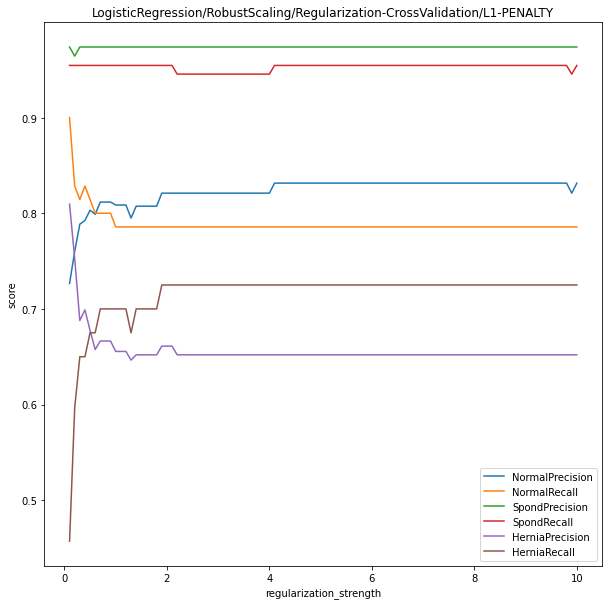

In [116]:
for i in scores:
    plt.plot(robust_results1['param_model__C'], robust_results1[f'mean_test_{i}'], label = i)
plt.legend()
plt.title('LogisticRegression/RobustScaling/Regularization-CrossValidation/L1-PENALTY')
plt.xlabel('regularization_strength')
plt.ylabel('score')

In [118]:
new_pipe = Pipeline([('transformer', RobustScaler()),
                     ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear'))])

In [126]:
new_grid = GridSearchCV(estimator = new_pipe, 
                       param_grid = {'model__class_weight':[{0:v-1,1:1,2:v} for v in range(2, 10)]},
                       n_jobs = -1,
                       scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                             cv = 5,
                       refit = 'SpondPrecision')

In [127]:
new_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [{0: 1, 1: 1, 2: 2},
                                                 {0: 2, 1: 1, 2: 3},
                                                 {0: 3, 1: 1, 2: 4},
                                                 {0: 4, 1: 1, 2: 5},
                                                 {0: 5, 1: 1, 2: 6},
                                                 {0: 6, 1: 1, 2: 7},
                                                 {0: 7, 1: 1, 2: 8},
                                                 {0: 8, 1: 1, 2: 9}]},
             refit='SpondPrecision',
             scoring={'HerniaPrecision': make_scorer(Herniaprecision),
                  

In [128]:
new_result = pd.DataFrame(new_grid.cv_results_)

Text(0, 0.5, 'score')

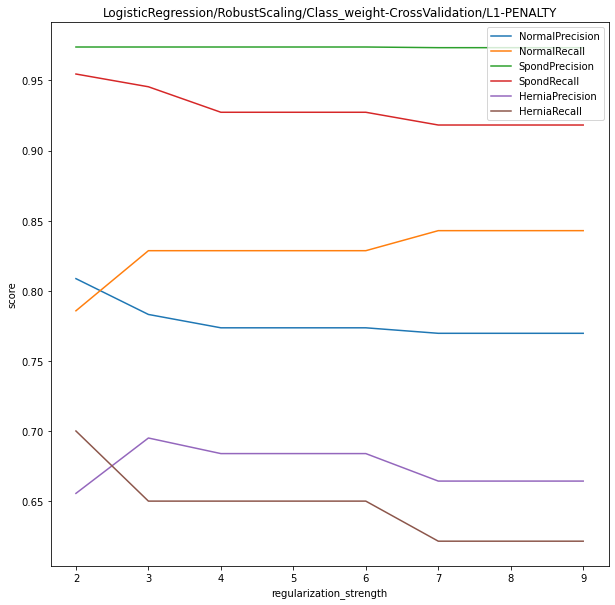

In [135]:
for i in scores:
    plt.plot(np.arange(2, 2+new_result.shape[0]), new_result[f'mean_test_{i}'], label = i)
plt.legend()
plt.title('LogisticRegression/RobustScaling/Class_weight-CrossValidation/L1-PENALTY')
plt.xlabel('regularization_strength')
plt.ylabel('score')

In [146]:
nnpipe = Pipeline([('transformer',RobustScaler()),
                  ('model',MLPClassifier(max_iter = 1000))])
hls = [[i, i] for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

In [147]:
nngrid = GridSearchCV(estimator = nnpipe,
                     param_grid = [{'model__hidden_layer_sizes':hls}],
                      n_jobs = -1,
                      scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                      cv = 5,
                      refit = 'SpondPrecision'
                     )

In [148]:
nngrid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model',
                                        MLPClassifier(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'model__hidden_layer_sizes': [[10, 10], [20, 20],
                                                        [30, 30], [40, 40],
                                                        [50, 50], [60, 60],
                                                        [70, 70], [80, 80],
                                                        [90, 90],
                                                        [100, 100]]}],
             refit='SpondPrecision',
             scoring={'HerniaPrecision': make_scorer(Herniaprecision),
                      'HerniaRecall': make_scorer(HerniaRecall),
                      'NormalPrecision': make_scorer(Normalprecision),
                      'NormalRecall': make_scorer(NormalRecall),
             

In [150]:
nnresult = pd.DataFrame(nngrid.cv_results_)
nnresult.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__hidden_layer_sizes', 'params',
       'split0_test_NormalPrecision', 'split1_test_NormalPrecision',
       'split2_test_NormalPrecision', 'split3_test_NormalPrecision',
       'split4_test_NormalPrecision', 'mean_test_NormalPrecision',
       'std_test_NormalPrecision', 'rank_test_NormalPrecision',
       'split0_test_NormalRecall', 'split1_test_NormalRecall',
       'split2_test_NormalRecall', 'split3_test_NormalRecall',
       'split4_test_NormalRecall', 'mean_test_NormalRecall',
       'std_test_NormalRecall', 'rank_test_NormalRecall',
       'split0_test_SpondPrecision', 'split1_test_SpondPrecision',
       'split2_test_SpondPrecision', 'split3_test_SpondPrecision',
       'split4_test_SpondPrecision', 'mean_test_SpondPrecision',
       'std_test_SpondPrecision', 'rank_test_SpondPrecision',
       'split0_test_SpondRecall', 'split1_test_SpondRecall',
       'split2_test_SpondRecall', '

Text(0, 0.5, 'score')

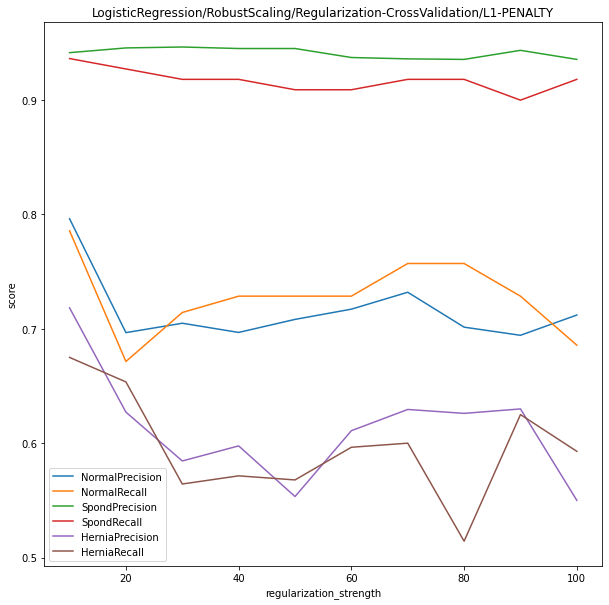

In [155]:
for i in scores:
    plt.plot([i for i, i in hls], nnresult[f'mean_test_{i}'], label = i)
plt.legend()
plt.title('LogisticRegression/RobustScaling/Regularization-CrossValidation/L1-PENALTY')
plt.xlabel('regularization_strength')
plt.ylabel('score')

In [154]:
scores

['NormalPrecision',
 'NormalRecall',
 'SpondPrecision',
 'SpondRecall',
 'HerniaPrecision',
 'HerniaRecall']